In [1]:
!pip3 install -U ucimlrepo
!pip install -U scikit-learn

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo, list_available_datasets

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
auto_mpg = fetch_ucirepo(id=9)

X = auto_mpg.data.features
y = auto_mpg.data.targets

In [125]:
df_features = pd.DataFrame(X, columns=auto_mpg.data.feature_names)

# initial power factor per cubic inch
pfci = 3.78

# filling missing values with apprx values using (displacement/cylinders) * pfci
df_features['horsepower'] = df_features['horsepower'].fillna((df_features['displacement'] / df_features['cylinders']) * pfci)

In [121]:
x_train, x_temp, y_train, y_temp = train_test_split(df_features, y, test_size = 0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [122]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_val_predict = model.predict(x_val_scaled)
y_test_predict = model.predict(x_test_scaled)

<!-- Make new my own data to predict target(mpg) -->

<!-- Implement my own example data -->

In [169]:
x_my_data = np.array([[396.0, 4, 101, 2866, 12.3, 99, 2]])
x_my_data_scaled = scaler.transform(x_my_data)

y_my_data = model.predict(x_my_data_scaled)

C:\Users\O_O\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [216]:
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(x_train_scaled, y_train)

y_ridge_predict = ridge_reg.predict(x_test_scaled)

In [210]:
# trying to find the best possible value of alpha for Ridge regularization
alphas = np.logspace(-3, 3, 7)
grid_search = GridSearchCV(estimator=ridge_reg, param_grid={'alpha': alphas}, scoring='r2', cv=4)
grid_search.fit(x_train_scaled, y_train)

print(f'Best alpha:{grid_search.best_params_}')
print(f'Best R^2:{grid_search.best_score_}')

Best alpha:{'alpha': 1.0}
Best R^2:0.7970650400062372


<!-- Predicted data score using data without regularization / using iniatial value of pfci -->

In [217]:
print(model.score(x_test_scaled, y_test))
print(model.score(x_test_scaled, y_ridge_predict))

print(f'MSE for test: {mean_squared_error(y_test, y_test_predict)}')
print(f'r2 score for test: {r2_score(y_test, y_test_predict)}')

print(f'MSE for ridge: {mean_squared_error(y_test, y_ridge_predict)}')
print(f'r2 score for test: {r2_score(y_test, y_ridge_predict)}')

0.8525868064633747
0.9999403485329461
MSE for test: 9.685036987810044
r2 score for test: 0.8525868064633747
MSE for ridge: 9.745883073899432
r2 score for test: 0.8516606854918255


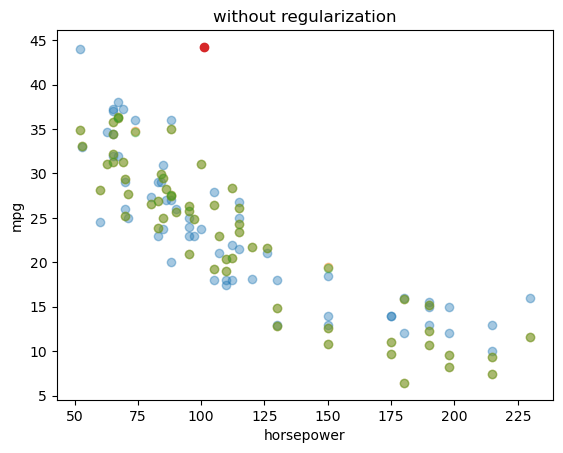

In [214]:
plt.scatter(x_test['horsepower'], y_test, alpha=0.4)
plt.scatter(x_test['horsepower'], y_test_predict, alpha=0.4)
plt.scatter(x_test['horsepower'], y_ridge_predict, alpha=0.4)
plt.scatter(x_my_data[0][2], y_my_data, alpha=1)

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('without regularization')
plt.show()